<a href="https://colab.research.google.com/github/Harsha0018/Wind-Speed-prediction/blob/main/wind%20speed%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Major Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy

## Other
import os, joblib, missingno

## sklearn -- Preprocessing & Tuning & Transformation
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures,OrdinalEncoder
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn_features.transformers import DataFrameSelector

## sklearn -- metrics
from sklearn.metrics import mean_squared_error, r2_score

## sklearn -- Models
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

## Xgboost
from xgboost import XGBRegressor

In [ ]:
pip install sklearn-features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving wind_dataset.csv to wind_dataset.csv


In [ ]:
import io
df = pd.read_csv(io.StringIO(uploaded['wind_dataset.csv'].decode('utf-8')))
df.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


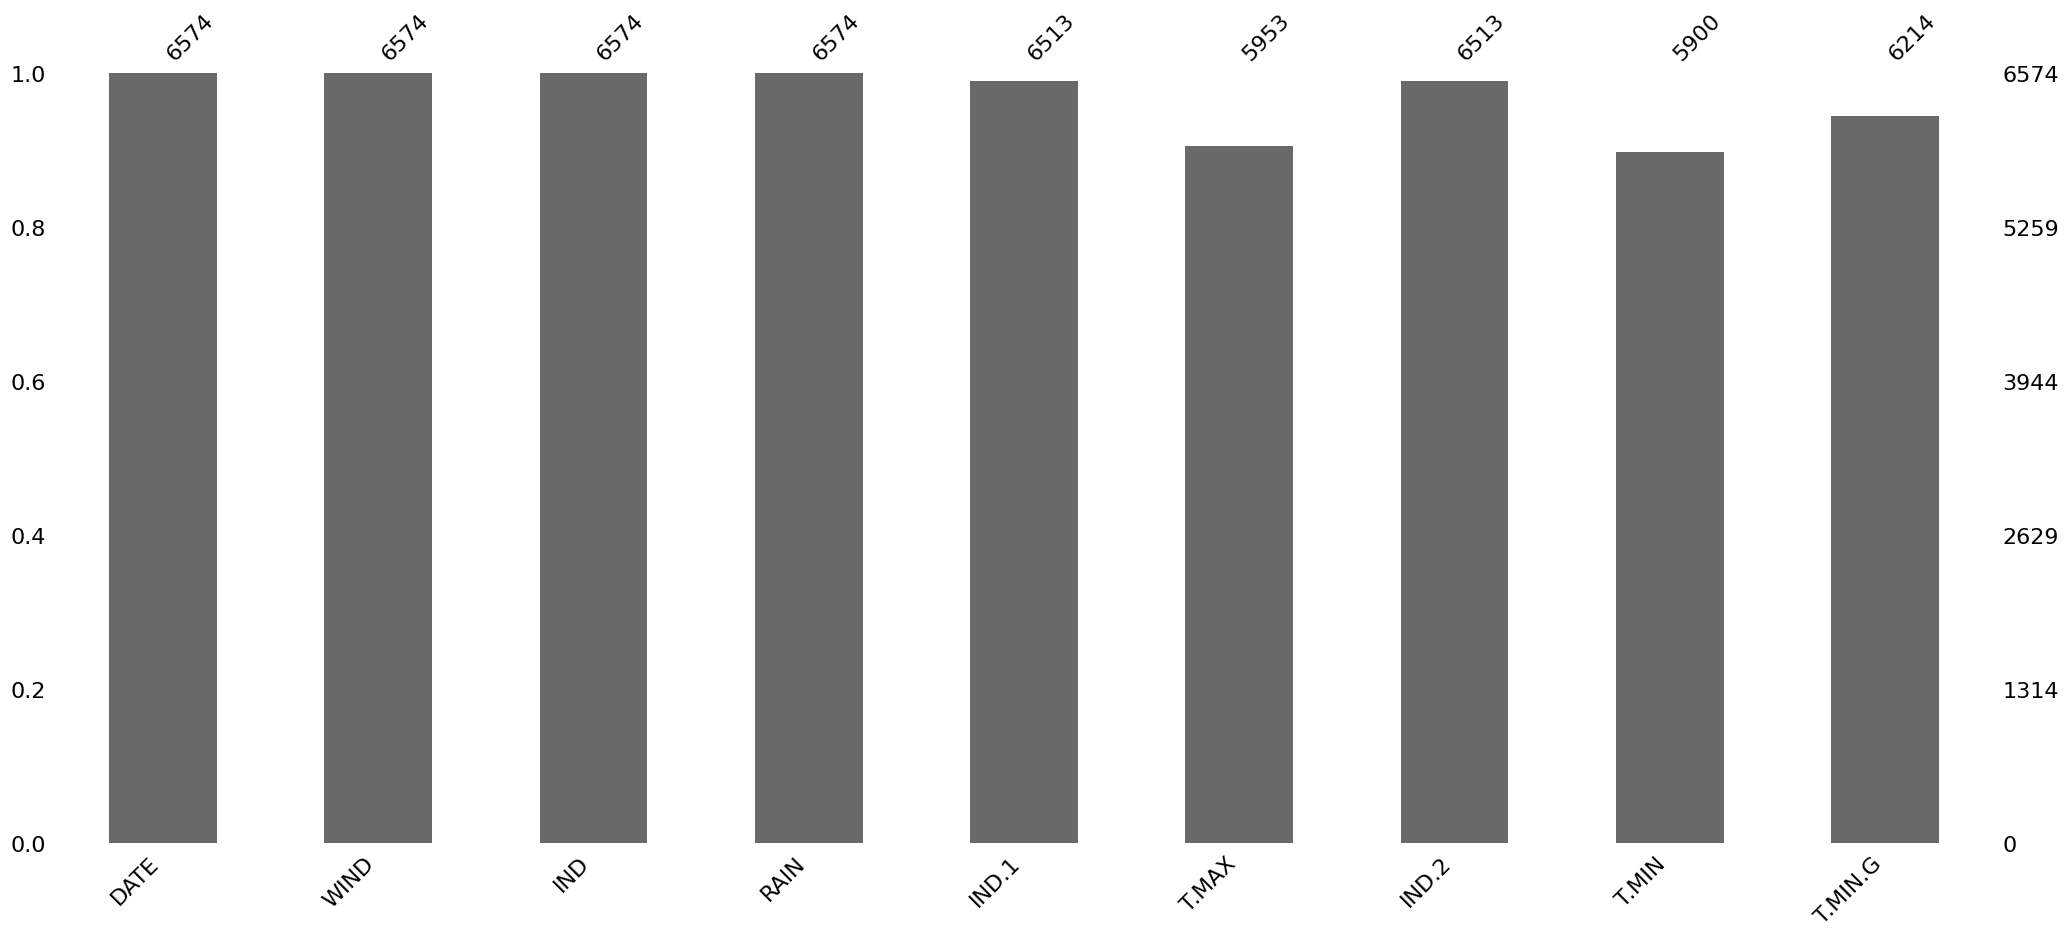

In [ ]:
df.isna().sum()
df.describe()
missingno.bar(df);

In [ ]:
df.corr()['WIND'].sort_values(ascending=False)

WIND       1.000000
RAIN       0.120876
IND.1      0.070512
IND.2      0.047860
T.MIN.G    0.012823
IND       -0.038578
T.MIN     -0.093014
T.MAX     -0.242559
Name: WIND, dtype: float64

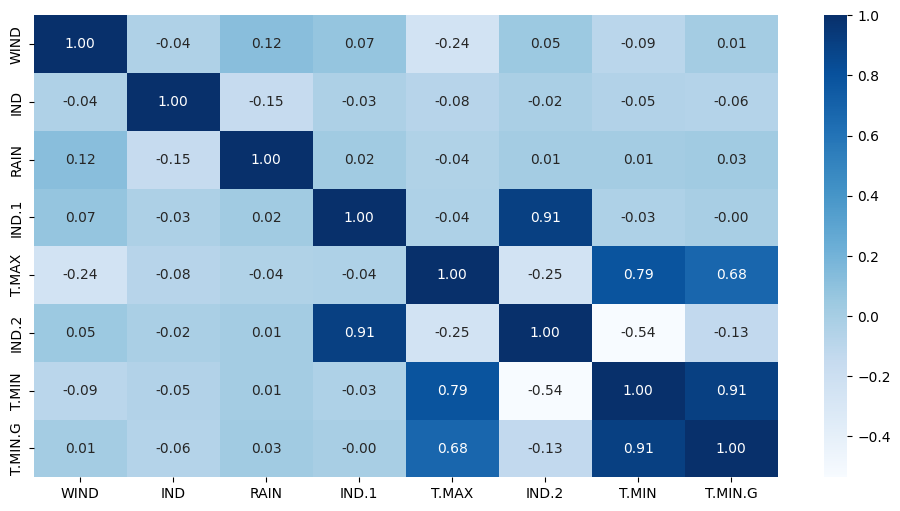

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap='Blues', fmt='.2f')  ## symmetric matrix
plt.show()

In [ ]:
df['DATE']=pd.to_datetime(df['DATE'])

In [ ]:
df['date_year']=df['DATE'].dt.year  #year
df['date_month_no']=df['DATE'].dt.month  #month
df['date_day']=df['DATE'].dt.day  # day
df=df.drop(columns=['DATE'])
df.head()

,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G,date_year,date_month_no,date_day
0,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0,1961,1,1
1,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1,1961,1,2
2,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5,1961,1,3
3,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2,1961,1,4
4,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5,1961,1,5


In [ ]:
## Split the whole Dataset to Feature & Target
X = df.drop(columns=['WIND'], axis=1)   ## Features
y = df['WIND']   ## target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=42)

## Check Shapes of these Sets
print('X_train shape -- ', X_train.shape)
print('y_train shape -- ', y_train.shape)
print('X_test shape -- ', X_test.shape)
print('y_test shape -- ', y_test.shape)

X_train shape --  (5587, 10)
y_train shape --  (5587,)
X_test shape --  (987, 10)
y_test shape --  (987,)


In [ ]:
num_pipeline = Pipeline(steps=[
                        ('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())
                              ]
                       )
## deal with (num_pipline) as an instance -- fit and transform to train dataset and transform only to other datasets
X_train_num = num_pipeline.fit_transform(X_train)  ## train
X_test_num = num_pipeline.transform(X_test)

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_num, y_train)

LinearRegression()

In [ ]:
rmse_scores_lin = cross_val_score(estimator=lin_reg, X=X_train_num, y=y_train,
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  ## sklearn deals with error as negative
rmse_scores_lin = -1 * rmse_scores_lin   ## we want it positive
rmse_scores_lin = np.sqrt(rmse_scores_lin)
print(f'RMSE Scores Using LinearRegression --- {np.round(rmse_scores_lin, 4)}')
print(f'Mean of RMSE Scores Using LinearRegression --- {rmse_scores_lin.mean():.4f}')


RMSE Scores Using LinearRegression --- [4.5252 4.6554 4.7454 4.6851 4.6596]
Mean of RMSE Scores Using LinearRegression --- 4.6541


In [ ]:
y_pred_test=lin_reg.predict(X_test_num)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'RMSE on test Dataset using linear regression -- {rmse_test:.3f}')


RMSE on test Dataset using linear regression -- 4.874


In [ ]:
sgd_reg = SGDRegressor(penalty='l2', alpha=0.0001, eta0=0.001, shuffle=True, max_iter=10000)  ## with Regularization


In [ ]:
rmse_scores_sgd = cross_val_score(estimator=sgd_reg, X=X_train_num, y=y_train,
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  ## sklearn deals with error as negative
rmse_scores_sgd = -1 * rmse_scores_sgd   ## we want it positive
rmse_scores_sgd = np.sqrt(rmse_scores_sgd)
print(f'RMSE Scores Using SGDRegressor --- {np.round(rmse_scores_sgd, 4)}')
print(f'Mean of RMSE Scores Using SGDRegressor --- {rmse_scores_sgd.mean():.4f}')


RMSE Scores Using SGDRegressor --- [4.5245 4.6544 4.7518 4.6935 4.6538]
Mean of RMSE Scores Using SGDRegressor --- 4.6556


In [ ]:
forest_reg = RandomForestRegressor(n_estimators=400, max_depth=18, max_samples=0.9, random_state=42, n_jobs=-1)
forest_reg.fit(X_train_num, y_train)

RandomForestRegressor(max_depth=18, max_samples=0.9, n_estimators=400,
                      n_jobs=-1, random_state=42)

In [ ]:
RandomForestRegressor(max_depth=18, max_samples=0.9, n_estimators=400,
                      n_jobs=-1, random_state=42)
rmse_scores_forest = cross_val_score(estimator=forest_reg, X=X_train_num, y=y_train,
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  ## sklearn deals with error as negative
rmse_scores_forest = -1 * rmse_scores_forest   ## we want it positive
rmse_scores_forest = np.sqrt(rmse_scores_forest)
print(f'RMSE Scores Using RandomForest --- {np.round(rmse_scores_forest, 4)}')
print(f'Mean of RMSE Scores Using RandomForest --- {rmse_scores_forest.mean():.4f}')


RMSE Scores Using RandomForest --- [4.094  4.3217 4.404  4.2198 4.2459]
Mean of RMSE Scores Using RandomForest --- 4.2571


In [ ]:
y_pred_test=forest_reg.predict(X_test_num)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'RMSE on test Dataset using RandomForest -- {rmse_test:.3f}')


RMSE on test Dataset using RandomForest -- 4.434


In [ ]:
## Using the Hero API -- XGBOOST
xgb_reg = XGBRegressor(n_estimators=150, max_depth=8, learning_rate=0.1, subsample=0.8)
xgb_reg.fit(X_train_num, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
rmse_scores_xgb = cross_val_score(estimator=xgb_reg, X=X_train_num, y=y_train,
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)  ## sklearn deals with error as negative
rmse_scores_xgb = -1 * rmse_scores_xgb   ## we want it positive
rmse_scores_xgb = np.sqrt(rmse_scores_xgb)
print(f'RMSE Scores Using Tuned XGBoost --- {np.round(rmse_scores_xgb, 4)}')
print(f'Mean of RMSE Scores Using XGBoost --- {rmse_scores_xgb.mean():.4f}')


RMSE Scores Using Tuned XGBoost --- [4.1604 4.2806 4.4154 4.2053 4.3012]
Mean of RMSE Scores Using XGBoost --- 4.2726


In [ ]:
y_pred_test=xgb_reg.predict(X_test_num)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f'RMSE on test Dataset using XGBRegressor -- {rmse_test:.3f}')


RMSE on test Dataset using XGBRegressor -- 4.347


https://www.kaggle.com/code/esraagabr/wind-speed-prediction
